# <font size='7'>Neural Machine Translation with Seq2Seq and Attention</font>

In [1]:
!pip install -q unidecode

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
from unidecode import unidecode
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:'SOS', 1:'EOS'}
        self.n_words = 2 # Count SOS and EOS
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
unidecode("Répétez s'il vous plaît")

"Repetez s'il vous plait"

In [5]:
def normalize_string(s):
    s = unidecode(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [6]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    lines = open("/kaggle/input/eng-fra/eng-fra.txt").read().strip().split('\n')
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [7]:
max_length = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length and p[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [8]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs)
    print(f"Trimed to {len(pairs)} sentence pairs")
    print("Counting words....")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print('Counted words.')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimed to 11452 sentence pairs
Counting words....
Counted words.
fra 4603
eng 2991
['je ne suis pas au courant de leurs decisions', 'i m not privy to their decisions']


In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        
        for i in range(max_length):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # W/o teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
                
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # None for consistency in the training loop
    
    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [11]:
def indexes_from_sentence(lang, sentence): return [lang.word2index[word] for word in sentence.split(' ')]
def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)
def tensor_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
    
    n = len(pairs)
    input_ids = np.zeros((n, max_length), dtype=np.int32)
    target_ids = np.zeros((n, max_length), dtype=np.int32)
    
    for idx, (inp, targ) in enumerate(pairs):
        inp_ids = indexes_from_sentence(input_lang, inp)
        targ_ids = indexes_from_sentence(output_lang, targ)
        inp_ids.append(EOS_token)
        targ_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(targ_ids)] = targ_ids
        
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                              torch.LongTensor(target_ids).to(device))
    
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [12]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn):
    total_loss = 0
    
    for data in dataloader:
        input_tensor, target_tensor = data
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        
        loss = loss_fn(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [13]:
import time, math

def as_mins(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m, s}"
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f"{as_mins(s)} (- {as_mins(rs)})"

In [14]:
def train(train_dataloader, encoder, decoder, n_epochs, lr=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    loss_fn = nn.NLLLoss()
    
    for epoch in range(1, n_epochs+1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn)
        print_loss_total += loss
        plot_loss_total += loss
        
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"{time_since(start, epoch/n_epochs)} ({epoch} {epoch/n_epochs*100}%) {print_loss_avg:.4f}")
            
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    show_plot(plot_losses)

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show();

In [16]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)
        
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [17]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training without attention

Reading lines...
Read 135842 sentence pairs
Trimed to 11452 sentence pairs
Counting words....
Counted words.
fra 4603
eng 2991
(1, 11.87213134765625) (- (17, 58.08197021484375)) (5 6.25%) 1.6891
(2, 24.760483264923096) (- (16, 53.32338285446167)) (10 12.5%) 0.9247
(3, 37.2399799823761) (- (15, 41.3732465902965)) (15 18.75%) 0.6160
(4, 50.41609811782837) (- (14, 31.248294353485107)) (20 25.0%) 0.4303
(6, 4.2836830615997314) (- (13, 21.424102735519455)) (25 31.25%) 0.3095
(7, 15.781086921691895) (- (12, 6.301811536153082)) (30 37.5%) 0.2302
(8, 27.718632459640503) (- (10, 52.781098876680744)) (35 43.75%) 0.1754
(9, 40.77030873298645) (- (9, 40.77030873298645)) (40 50.0%) 0.1366
(10, 54.20808792114258) (- (8, 28.828512827555414)) (45 56.25%) 0.1098
(12, 6.485514163970947) (- (7, 15.891308498382614)) (50 62.5%) 0.0910
(13, 19.573156595230103) (- (6, 3.4423439069228152)) (55 68.75%) 0.0768
(14, 33.87362241744995) (- (4, 51.29120747248339)) (60 75.0%) 0.0666
(15, 49.36276388168335) (- (3, 39

<Figure size 640x480 with 0 Axes>

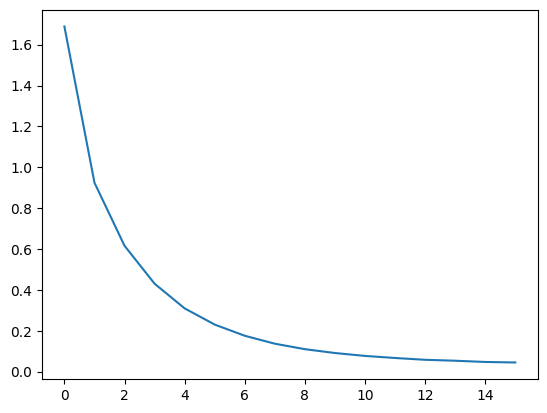

In [18]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [19]:
encoder.eval()
decoder.eval()

evaluate_randomly(encoder, decoder)

> je suis touchee
= i m touched
< i m hit the school now now <EOS>

> je ne suis plus fatiguee
= i am no longer tired
< i am no match for the accident <EOS>

> je suis tres fatigue
= i am very tired
< i am very tired from the job <EOS>

> quel idiot tu es !
= you re such an idiot !
< you are such a jerk <EOS>

> tu es celui qui m a entraine
= you re the one who trained me
< you re the one who trained me <EOS>

> nous avons de la visite
= we re having company
< we re halfway there <EOS>

> je suis moins heureux maintenant
= i m not as happy now
< i m really as old as tom <EOS>

> je suis en train de reamenager
= i m remodeling
< i m learning the station <EOS>

> je creve de froid
= i m freezing cold
< i m getting sleepy <EOS>

> vous etes fort effrontees
= you re very forward
< you are all very good with me are you ?



# Bahdanau Attention

- also known as additive attention or global attention
- Primary purpose is to help the model focus on different parts of the input sequence while generating each element of the output sequence.
- It allows the model to adaptively attend to different parts of the input sequence during the decoding process, which is crucial for handling long sequences and capturing relevant information for the task at hand.

How it works:
1. **Input Sequence**: Consider an input sequence of word embeddings or tokens, that the model needs to process and translate or generate from.
2. **Encoder-Decoder Architecture**: The input sequence is encoded into a fixed-length representation by an encoder, typically using RNNs or other sequential models.
3. **Attention Scores**: The decoder calculates attention scores for each position in the input sequence. These attention scores determine how much focus the model should give to each input position when generating the current output element.
4. **Softmax**: The attention scores are passes through a softmax function to convert them into probability distributions. This makes the attention mechanism differentiable and ensures that the sum of attention weights for all positions is equal to 1.
5. **Weighted Sum**: The output of the attention mechanism is a weighted sum of the encoder's hidden states(outputs). Each hidden state is multiplied by its corresponding attention weight and then summed to create the context vector.
6. **Context Vector**: The context vector is used as an additional input to the decoder, providing it with info about which parts of the input sequence to focus on while generating the next element in the output sequence.
7. **Decoding**: The decoder used the context vector, along with its internal state and previously generated elements, to predict the next element in the output sequence. This process is repeated until the entire output sequence is generated.

In [20]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        
        return context, weights

In [21]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []
        
        for i in range(max_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)
            
            if target_tensor is not None:
                # Teacher forcing
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # W/O teacher forcing
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        
        return decoder_outputs, decoder_hidden, attentions
    
    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        
        return output, hidden, attn_weights

Reading lines...
Read 135842 sentence pairs
Trimed to 11452 sentence pairs
Counting words....
Counted words.
fra 4603
eng 2991
(1, 38.74981999397278) (- (24, 41.247299909591675)) (5 6.25%) 1.5504
(3, 16.91336727142334) (- (22, 58.39357089996338)) (10 12.5%) 0.6981
(4, 54.87288212776184) (- (21, 17.782489220301386)) (15 18.75%) 0.3623
(6, 34.20036268234253) (- (19, 42.60108804702759)) (20 25.0%) 0.1998
(8, 12.230256795883179) (- (18, 2.906564950942993)) (25 31.25%) 0.1227
(9, 50.82336497306824) (- (16, 24.705608288447138)) (30 37.5%) 0.0848
(11, 31.503962755203247) (- (14, 49.076523542404175)) (35 43.75%) 0.0642
(13, 9.151357889175415) (- (13, 9.151357889175415)) (40 50.0%) 0.0523
(14, 49.47411108016968) (- (11, 31.813197506798588)) (45 56.25%) 0.0459
(16, 33.65168213844299) (- (9, 56.191009283065796)) (50 62.5%) 0.0405
(18, 14.452972650527954) (- (8, 17.4786239320581)) (55 68.75%) 0.0374
(19, 55.18586754798889) (- (6, 38.395289182662964)) (60 75.0%) 0.0346
(21, 34.82810592651367) (- (4

<Figure size 640x480 with 0 Axes>

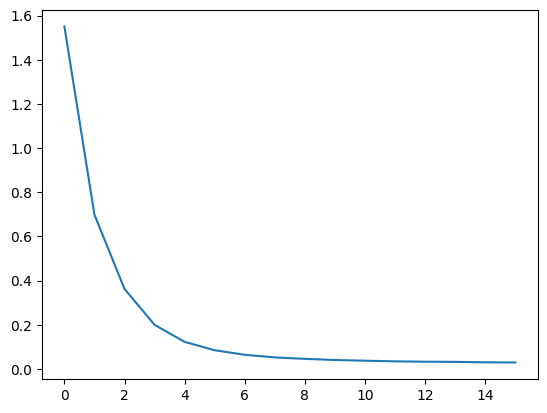

In [22]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [23]:
encoder.eval()
decoder.eval()
evaluate_randomly(encoder, decoder)

> je ne suis pas institutrice
= i m not a teacher
< i m not a teacher <EOS>

> je suis etudiant
= i am a university student
< i m a student <EOS>

> vous ne devez pas quitter cette piece
= you are not to leave this room
< you are not to leave this room room <EOS>

> nous sommes pretes
= we re ready
< we re ready for this <EOS>

> nous avons un hiver doux cette annee
= we are having a mild winter
< we are having a mild winter <EOS>

> je suis le plus grand de notre classe
= i am the tallest in our class
< i am the tallest in our class <EOS>

> je suis votre debiteur
= i am in your debt
< i am in your debt <EOS>

> je suis en cours de concentration
= i m concentrating
< i m concentrating <EOS>

> c est un ecrivain de talent
= he s a talented writer
< he s a talented writer <EOS>

> je suis partant pour aller ou que tu ailles
= i m willing to go anywhere you go
< i m willing to go anywhere you go <EOS>



In [24]:
def show_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [25]:
def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipykernel_20/262605619.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_20/262605619.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


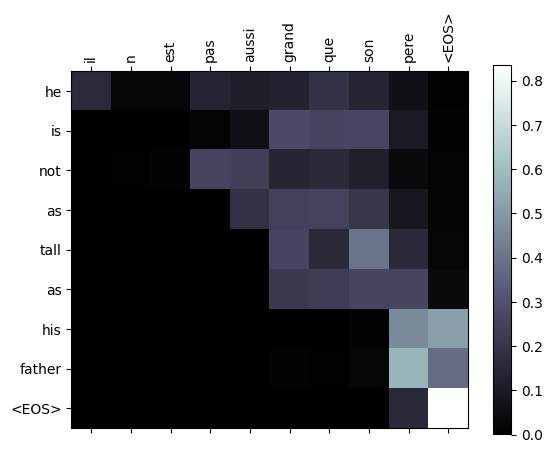

In [26]:
evaluate_and_show_attention('il n est pas aussi grand que son pere')

input = je suis trop fatigue pour conduire
output = i m too sleepy to drive <EOS>


/tmp/ipykernel_20/262605619.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_20/262605619.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


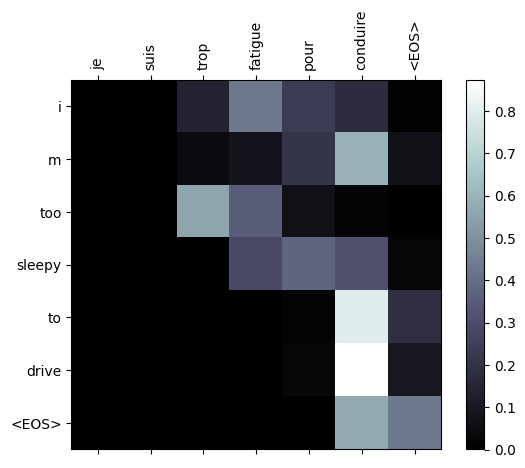

In [27]:
evaluate_and_show_attention('je suis trop fatigue pour conduire')

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


/tmp/ipykernel_20/262605619.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_20/262605619.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


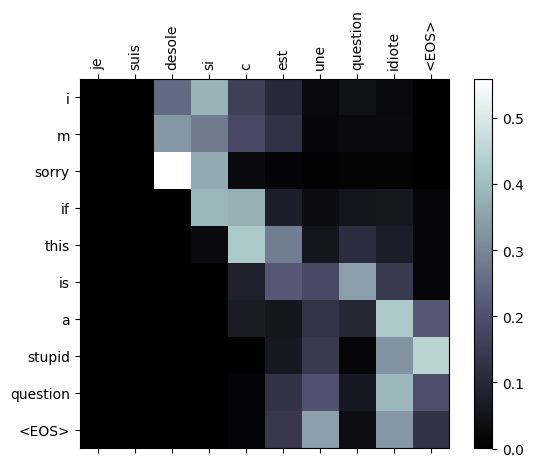

In [28]:
evaluate_and_show_attention('je suis desole si c est une question idiote')

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


/tmp/ipykernel_20/262605619.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_20/262605619.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


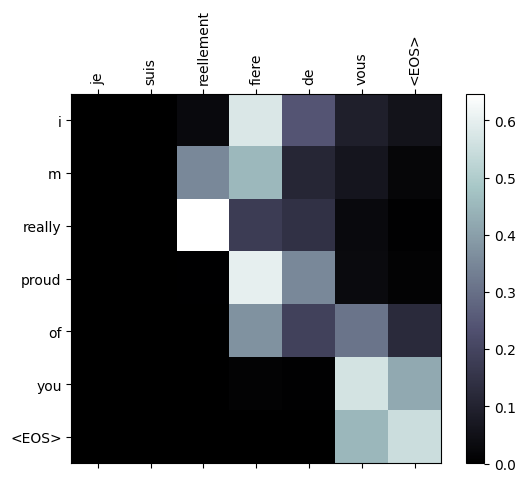

In [29]:
evaluate_and_show_attention('je suis reellement fiere de vous')